

--- Initializing Critically Damped Langevin ---
Pre-computing Critically Damped Langevin analytical moments...
Running demonstration for Critically Damped Langevin...
Solving forward SDE for Critically Damped Langevin...
Solving reverse SDE for Critically Damped Langevin with Euler-Maruyama...


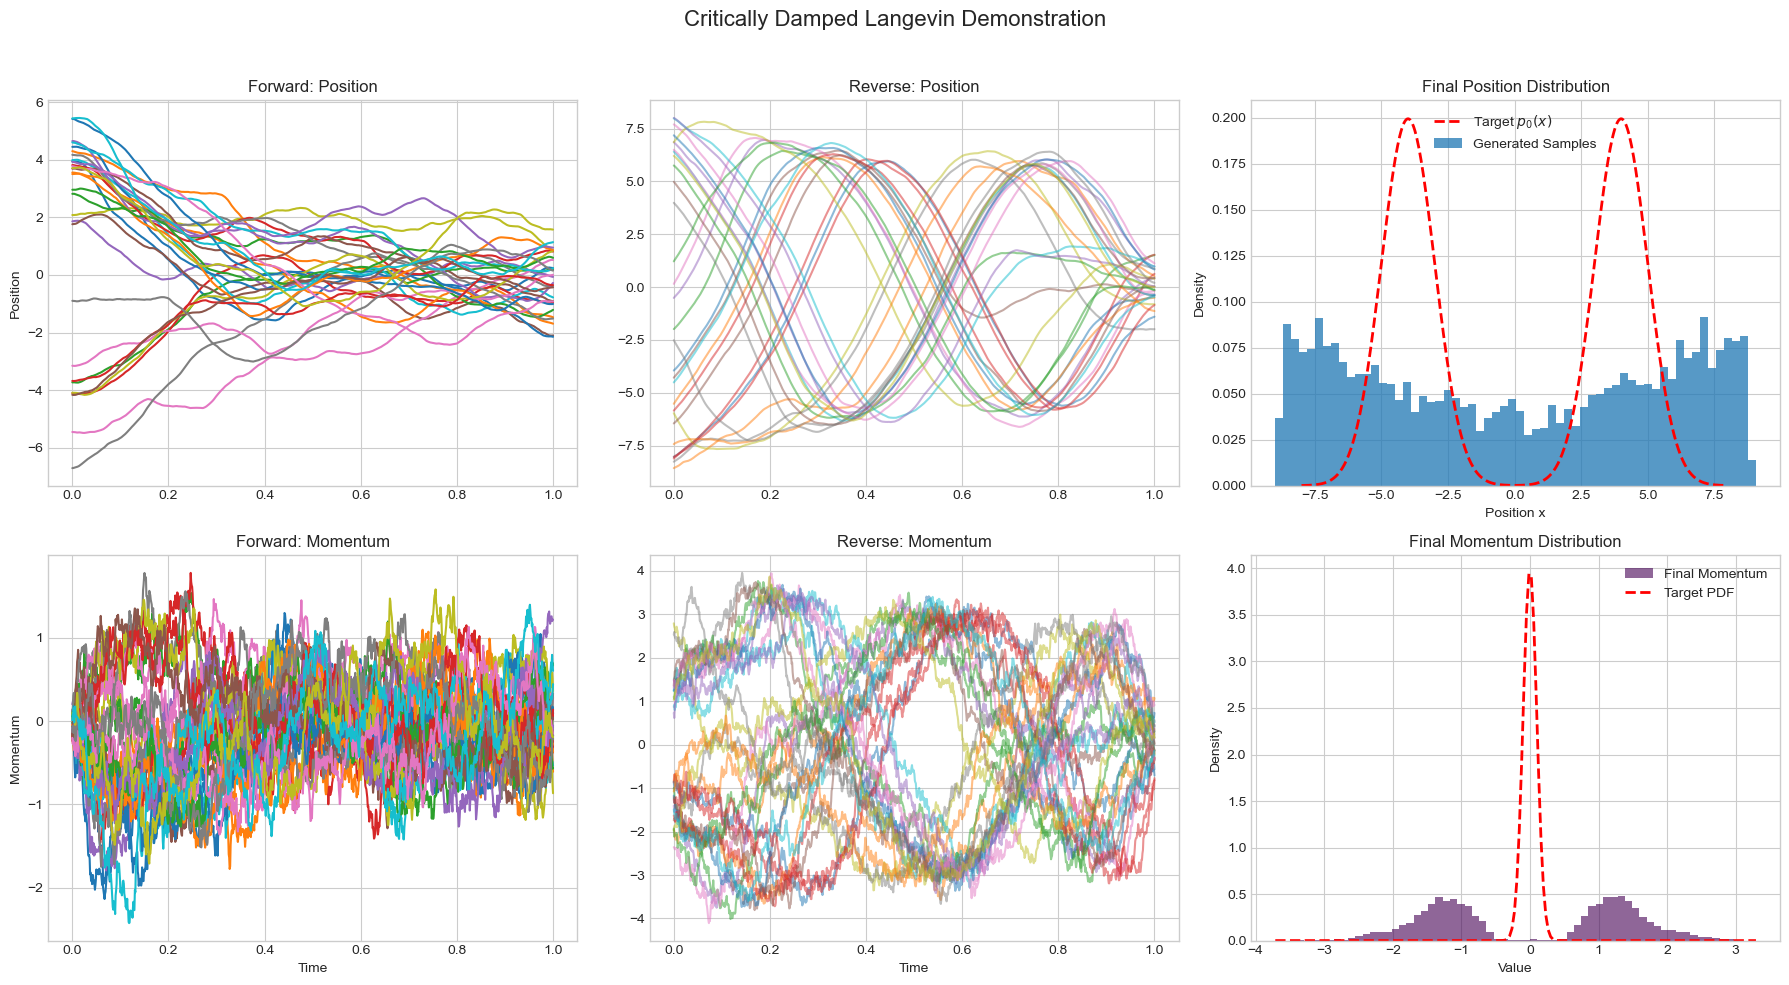



--- Initializing Generalized Langevin Diffusion ---
Precomputing perturbation kernels analytically...
Precomputation finished.

Running demonstration for Generalized Langevin Diffusion...
Solving forward SDE for Generalized Langevin Diffusion...
Precomputing matrices for SSCS solver...
SSCS precomputation finished.
Solving reverse SDE for Generalized Langevin Diffusion with SSCS...
Solving reverse PF-ODE for Generalized Langevin Diffusion...


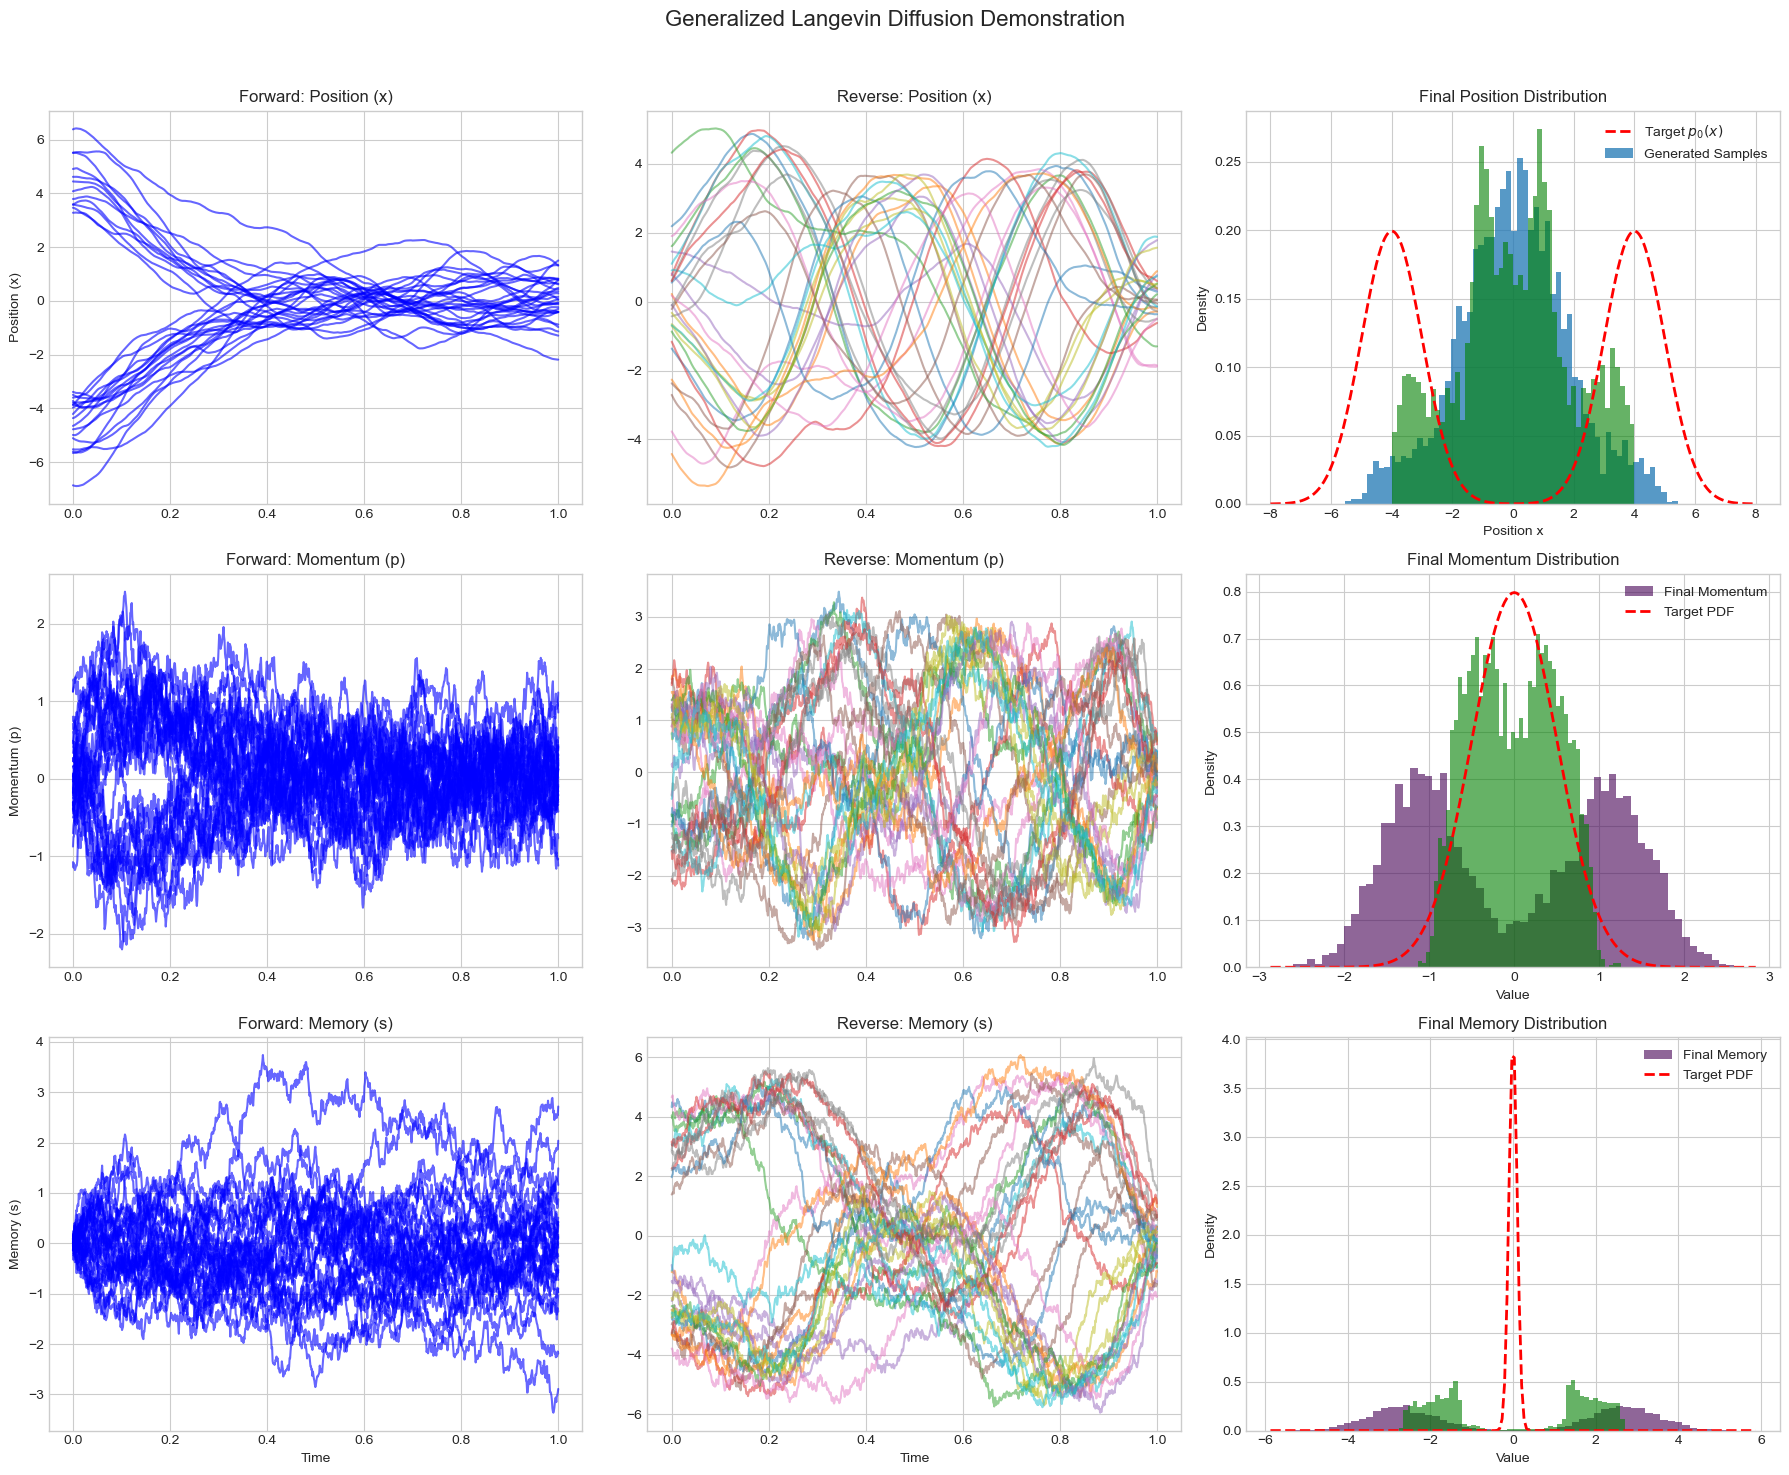

In [1]:
# Why is there a difference in behaviour between 0 score CLD and 0 score GLD?
import torch
import matplotlib.pyplot as plt
import numpy as np
from diffusion.vpsde import VPSDE
from diffusion.cld import CriticallyDampedLangevin
from diffusion.gld import GeneralizedLangevinDiffusion

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GMM_PARAMS = {
    'weights': [0.5, 0.5],
    'means': [-4., 4.],
    'stds': [1.,1.]
}

n_plot, n_hist = 30, 5000

# vpsde_model = VPSDE(GMM_PARAMS)
# vpsde_model.run_demonstration(n_plot, n_hist)

print("\n" + "="*80 + "\n")

cld_model = CriticallyDampedLangevin(GMM_PARAMS)
cld_model.run_demonstration(n_plot, n_hist)

print("\n" + "="*80 + "\n")

gld_model = GeneralizedLangevinDiffusion(GMM_PARAMS)
gld_model.run_demonstration(n_plot, n_hist)

Calculating eigenvalues and generating 3D plots...


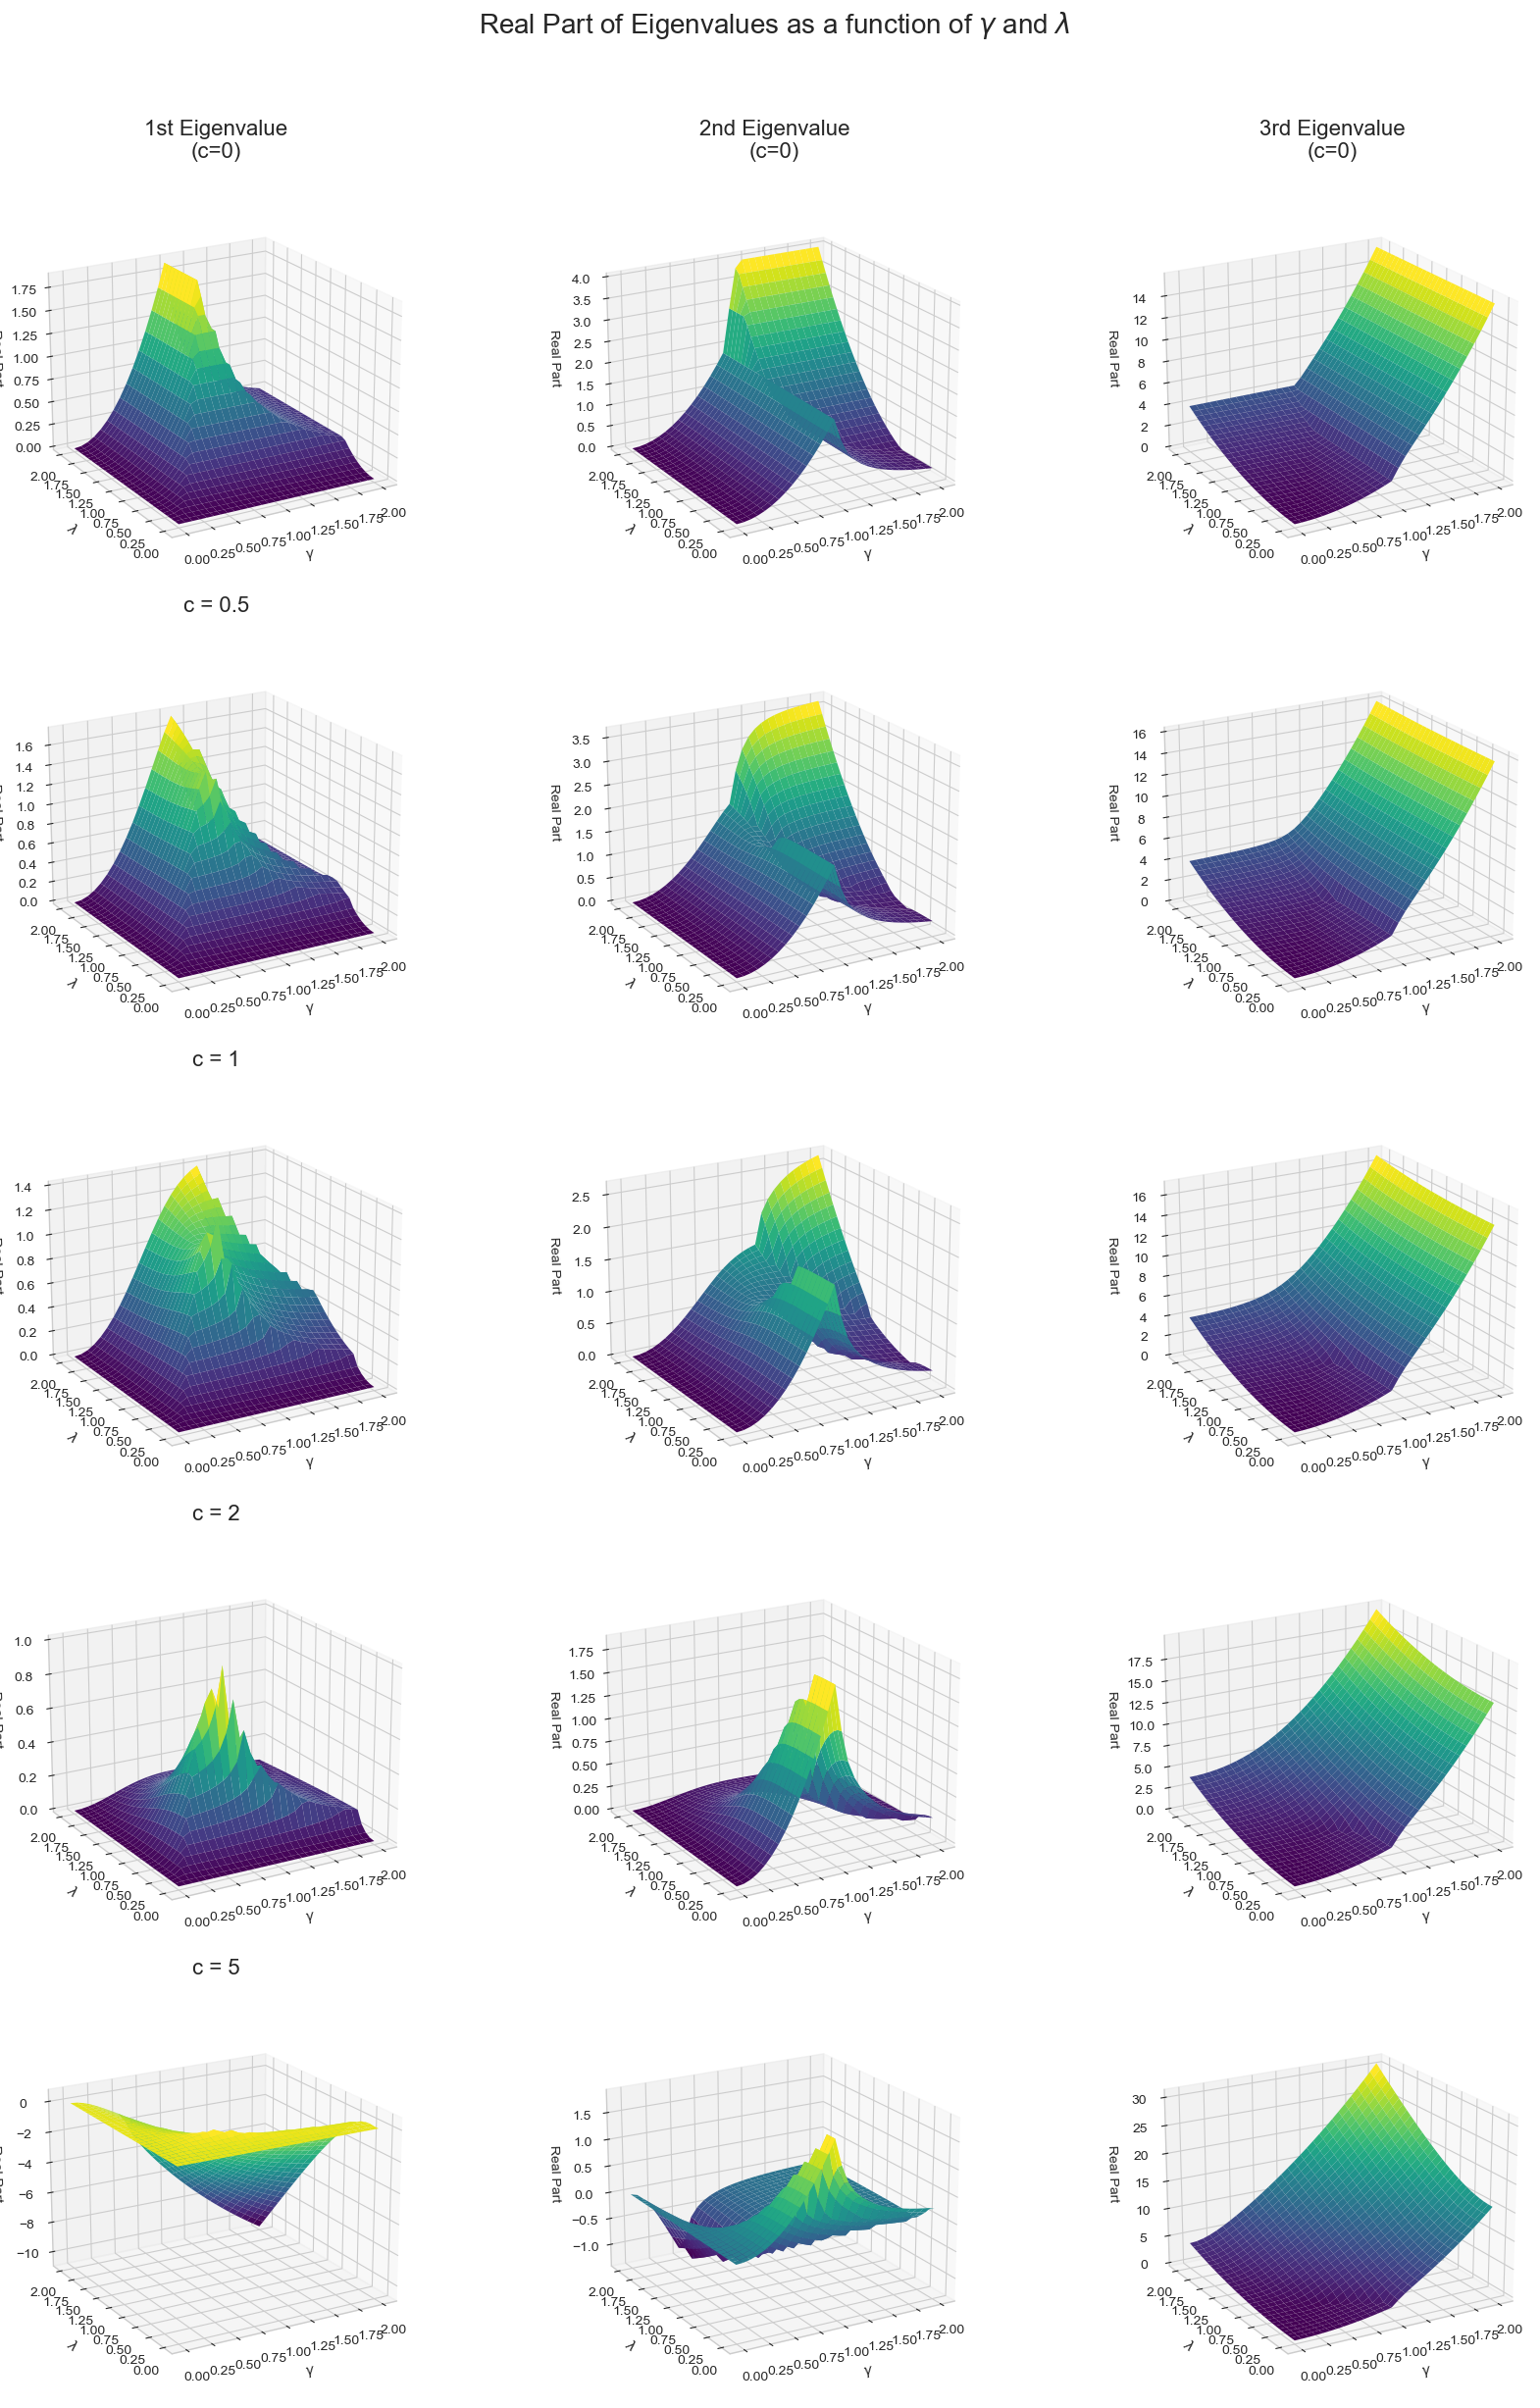

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_eigenvalues(gamma, lamb, c):
    """
    Calculates the real parts of the eigenvalues of matrix A.

    Args:
      gamma: The value of gamma.
      lamb: The value of lambda.
      c: The value of c.

    Returns:
      A sorted numpy array containing the real parts of the three eigenvalues.
    """
    M_inv = 4.0  # Since M = 0.25
    # Define the matrix A
    A = np.array([
        [0, -M_inv, 0],
        [1, M_inv * gamma**2, gamma * lamb * c],
        [0, gamma * lamb * c, lamb**2]
    ])
    # Calculate eigenvalues
    eigenvals = np.linalg.eigvals(A)
    # Return the sorted real parts of the eigenvalues
    return np.sort(np.real(eigenvals))

# --- Configuration ---
# Define the specific c values for each row of plots
c_values = [0, 0.5, 1, 2, 5]
n_points = 30  # Resolution for gamma and lambda axes, kept lower for faster 3D rendering

# Define the ranges for gamma and lambda
gamma_range = np.linspace(0, 2, n_points)
lambda_range = np.linspace(0, 2, n_points)
G, L = np.meshgrid(gamma_range, lambda_range)

# --- Create the Plot Grid ---
# One row for each c_value, three columns for the three eigenvalues, with 3D projection
fig, axs = plt.subplots(len(c_values), 3, figsize=(18, 25), subplot_kw={'projection': '3d'})
fig.suptitle('Real Part of Eigenvalues as a function of $\gamma$ and $\lambda$', fontsize=20, y=0.98)

print("Calculating eigenvalues and generating 3D plots...")

# --- Generate Data and Plot ---
for i, c in enumerate(c_values):
    # Initialize grids to store the eigenvalue results for the current 'c'
    eig1_grid = np.zeros_like(G)
    eig2_grid = np.zeros_like(G)
    eig3_grid = np.zeros_like(G)

    # Calculate eigenvalues for each point in the (gamma, lambda) grid
    for j in range(n_points):
        for k in range(n_points):
            gamma = G[j, k]
            lamb = L[j, k]
            e1, e2, e3 = get_eigenvalues(gamma, lamb, c)
            eig1_grid[j, k] = e1
            eig2_grid[j, k] = e2
            eig3_grid[j, k] = e3
    
    # Store the grids for plotting
    eigenvalue_grids = [eig1_grid, eig2_grid, eig3_grid]
    
    # Set the title for the row, indicating the 'c' value
    # This is done by setting the title of the first plot in the row
    axs[i, 0].set_title(f'c = {c}', fontsize=16, pad=20)


    # Plot the three eigenvalue distributions in the three columns
    for col_idx, eig_grid in enumerate(eigenvalue_grids):
        ax = axs[i, col_idx]
        # Use plot_surface to create a 3D surface plot
        ax.plot_surface(G, L, eig_grid, cmap='viridis', edgecolor='none')
        
        # Set labels for the axes
        ax.set_xlabel('$\gamma$')
        ax.set_ylabel('$\lambda$')
        ax.set_zlabel('Real Part')
        ax.view_init(elev=20., azim=-120) # Set a consistent viewing angle


# --- Customize the Plot ---
# Set titles for the columns on the top row
axs[0, 0].set_title('1st Eigenvalue\n(c=0)', fontsize=16, pad=20)
axs[0, 1].set_title('2nd Eigenvalue\n(c=0)', fontsize=16, pad=20)
axs[0, 2].set_title('3rd Eigenvalue\n(c=0)', fontsize=16, pad=20)


# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
